In [1]:
import pandas as pd
import numpy as np
import random
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.environ import SolverFactory
import yfinance as yf
import matplotlib.pyplot as plt

## MODELO DE OTIMIZAÇÂO ROBUSTA
# Resolver o overfitting (modelos feitos c base no passado)
# Trabalhar com a incerteza!! 
# Orçamento de incerteza

In [244]:
retornos_ativos2=pd.read_csv('retornos_ativos2.csv').set_index(['Date'])
retorno_ibov2=pd.read_csv('retorno_ibov2.csv').set_index(['Date']).dropna()

In [245]:
print(retorno_ibov2.shape)
print(retornos_ativos2.shape)
print(np.int32(len(retornos_ativos2)/5*4))
print(np.int32(len(retorno_ibov2)/5*4))
# retornos_ativos2 = retornos_ativos2[0:np.int32(len(retornos_ativos2)/5*4)]
# retornos_ativos_projecao = retornos_ativos2[np.int32(len(retornos_ativos2)/5*4):]
# retorno_ibov2 = retorno_ibov2[0:np.int32(len(retorno_ibov2)/5*4)]
# retorno_ibov_projecao = retorno_ibov2[np.int32(len(retorno_ibov2)/5*4):]
print(retorno_ibov2.shape)
print(retornos_ativos2.shape)

(168, 1)
(168, 85)
134
134
(168, 1)
(168, 85)


In [246]:
dicio_ativos = {}
for t in range(len(retornos_ativos2)):
    for a in range(len(retornos_ativos2.columns)):
        dicio_ativos[t,a] = retornos_ativos2.iloc[t,a]

dicio_ibov = {}
for t in range(len(retorno_ibov2)):
    dicio_ibov[t] = retorno_ibov2['IBOV'].iloc[t]



In [247]:
std_ativos = retornos_ativos2.std()
std_ativos = pd.DataFrame(std_ativos, columns=['desvio_padrao'])
dicio_std = {}
for a in range(len(retornos_ativos2.columns)):
    dicio_std[a] = std_ativos['desvio_padrao'].iloc[a]


## INICIAR MODELO

In [253]:
model = pyo.ConcreteModel()

# RANGE SET
model.A = pyo.RangeSet(0,len(retornos_ativos2.columns)-1)
model.T = pyo.RangeSet(0, len(retornos_ativos2)-1)

# PARAMETROS----------------------
model.ATIVOS = pyo.Param(model.T,model.A, initialize=dicio_ativos)
model.IBOV = pyo.Param(model.T, initialize=dicio_ibov)
model.DELTA = pyo.Param(model.A, initialize = dicio_std)
    ##----------------- GAMA: Orçamento de Incerteza -> Defini quantos ativos podem variar ao mesmo tempo (Seguro geral)
        ##  ------ mutable = True -> define parâmetros que podem ser alterados entre execuções de otimização sem reconstruir o modelo
            ##----model.GAMA = 2.0  # Forma simples  OU model.GAMA.store(2.0)
model.GAMA = pyo.Param(initialize = 5.0, mutable = True)
model.QUANTIDADE_ATIVOS = pyo.Param(initialize = 20.0)

# VARIAVEIS----------------------
model.x = pyo.Var(model.A, bounds=(0,1))
model.y = pyo.Var(model.A, within=pyo.Binary)
    ## Para cada dia $t$, o modelo precisa de variáveis extras para "absorver" a incerteza: z[t]: Uma variável global de proteção para o dia $t$. p[t, a]: Uma variável de proteção específica para cada ativo no dia $t$.
model.z = pyo.Var(model.T, bounds=(0,None))
model.p = pyo.Var(model.T, model.A, bounds=(0,None))



# OBJETIVO----------------------
def func_objetivo_1(model):
    erro_tracking = sum(
        (sum(model.ATIVOS[t,a] * model.x[a] for a in model.A) - model.IBOV[t] )**2 
        for t in model.T
    ) 

    ## Termo de proteção Robusta -----------
    protecao = sum(
        (model.GAMA * model.z[t] + sum(model.p[t,a] for a in model.A)) for t in model.T
    )

    return erro_tracking + protecao

model.obj = pyo.Objective(rule=func_objetivo_1,sense=pyo.minimize)



In [254]:
# RESTRICOES ----------------------
    ## - Ela diz que a proteção deve ser maior ou igual ao impacto do desvio padrão no peso do ativo
def regra_protecao(model,t,a):
    
    return model.z[t] + model.p[t,a] >= model.DELTA[a] * model.x[a]

model.con_protecao = pyo.Constraint(model.T,model.A, rule=regra_protecao)

    ## OUTRAS RESTRIÇÔES

    # 1- Cardinalidade (total ativos na carteira)
def cardinalidade(model):

    return sum(
        model.y[a] for a in model.A
    ) == model.QUANTIDADE_ATIVOS
model.cardinalidade = pyo.Constraint(rule=cardinalidade)

    # 2 - Soma peso da carteira
def soma_peso_1(model):
    return sum(model.x[a] for a in model.A) == 1
model.soma_peso_1 = pyo.Constraint(rule=soma_peso_1)

    # 3 - x só ativa se y=1
def restr_vinculo_x_y(model, a):

    return model.x[a] <= model.y[a]

model.restr_vinculo_x_y = pyo.Constraint(model.A, rule=restr_vinculo_x_y)





In [ ]:
opt = SolverFactory('cplex', executable='C:\\CPLEX_Studio2211\\cplex\\bin\\x64_win64\\cplex.exe')
opt.options['TimeLimit'] = 480
# resultado = opt.solve(model)
opt.options['optimalitytarget'] = 3 
results = opt.solve(model, tee=True)
print("-------FIM----------")


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 22.1.1.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2022.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\DECIV\AppData\Local\Temp\tmprrpph4di.cplex.log' open.
CPLEX> New value for time limit in seconds: 300
CPLEX> New value for type of solution CPLEX will attempt to compute: 3
CPLEX> Problem 'C:\Users\DECIV\AppData\Local\Temp\tmpzght3zj7.pyomo.lp' read.
Read time = 0.01 sec. (2.34 ticks)
CPLEX> Problem name         : C:\Users\DECIV\AppData\Local\Temp\tmpzght3zj7.pyomo.lp
Objective sense      : Minimize
Variables            :   14702  [Nneg: 14531,  Fix: 1,  Box: 85,  Binary: 85,
                                 Qobj: 168]
Objective nonzeros   :   14534
Objective Q nonzeros :    7225
Line

           peso_ativo  ativado
VALE3.SA     0.048147      1.0
ITUB4.SA     0.049491      1.0
PETR4.SA     0.051509      1.0
ITSA4.SA     0.048571      1.0
ABEV3.SA     0.048552      1.0
VIVT3.SA     0.047650      1.0
BBDC3.SA     0.049090      1.0
GGBR4.SA     0.047339      1.0
CMIG4.SA     0.047465      1.0
BBSE3.SA     0.062152      1.0
ENGI11.SA    0.043612      1.0
ALOS3.SA     0.046835      1.0
ISAE4.SA     0.053712      1.0
MULT3.SA     0.045935      1.0
CXSE3.SA     0.056490      1.0
TAEE11.SA    0.055651      1.0
CPFE3.SA     0.049708      1.0
GOAU4.SA     0.045184      1.0
IGTI11.SA    0.045725      1.0
SLCE3.SA     0.057183      1.0
135.58982999595952
136.37877244960143
138.52553258489547


C:\Users\DECIV\AppData\Local\Temp\ipykernel_10180\1779441119.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_otimizado[-1])
C:\Users\DECIV\AppData\Local\Temp\ipykernel_10180\1779441119.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_equi[-1])
C:\Users\DECIV\AppData\Local\Temp\ipykernel_10180\1779441119.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_ibov[-1])


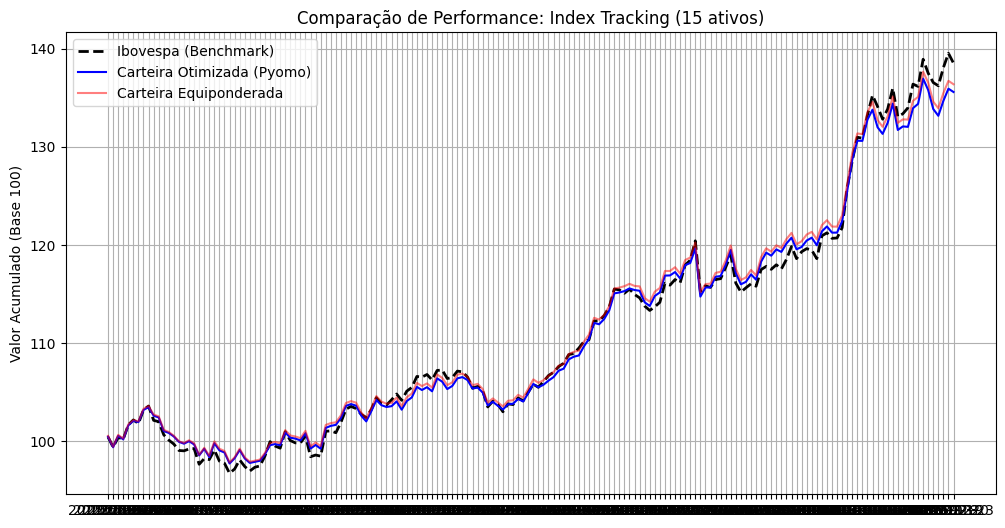

In [ ]:
lsita_grande = []
for numero in range(len(retornos_ativos2.columns)):
    peso_ativo = pyo.value(model.x[numero])
    ativado = pyo.value(model.y[numero])
    lista = [peso_ativo, ativado]
    lsita_grande.append(lista)
    
final = pd.DataFrame(lsita_grande, columns=["peso_ativo","ativado"], index=retornos_ativos2.columns)
print(final[final['ativado']==1])
df_final = final[final['ativado']==1]
# df_final.head()
ativos_selecionados = df_final.index
retornos_carteira= retornos_ativos2[ativos_selecionados]

carteira_otimizada = (retornos_carteira*df_final['peso_ativo']).sum(axis=1)
carteira_otimizada = 1 + carteira_otimizada
#criar a carteira equiponderada, com pesos iguais

carteira_equi = retornos_carteira.mean(axis=1)
carteira_equi = 1 + carteira_equi

# 3. Transformar em Retorno Acumulado (Base 100)
acum_otimizado = (carteira_otimizada).cumprod() * 100
acum_equi = (carteira_equi).cumprod() * 100
acum_ibov = (1 + retorno_ibov2['IBOV']).cumprod() * 100

print(acum_otimizado[-1])
print(acum_equi[-1])
print(acum_ibov[-1])

qnt_carteira = pyo.value(model.QUANTIDADE_ATIVOS)
texto = f'Comparação de Performance: Index Tracking ({qnt_carteira} ativos)'

# 4. Plotar o Gráfico
plt.figure(figsize=(12, 6))
plt.plot(acum_ibov, label='Ibovespa (Benchmark)', color='black', linewidth=2, linestyle='--')
plt.plot(acum_otimizado, label='Carteira Otimizada (Pyomo)', color='blue')
plt.plot(acum_equi, label='Carteira Equiponderada', color='red', alpha=0.5)

plt.title(texto)
plt.ylabel('Valor Acumulado (Base 100)')
plt.legend()
plt.grid(True)
plt.show()

In [252]:
model.pprint()


2 RangeSet Declarations
    A : Dimen=1, Size=85, Bounds=(0, 84)
        Key  : Finite : Members
        None :   True :  [0:84]
    T : Dimen=1, Size=168, Bounds=(0, 167)
        Key  : Finite : Members
        None :   True : [0:167]

4 Param Declarations
    ATIVOS : Size=14280, Index=T*A, Domain=Any, Default=None, Mutable=False
        Key       : Value
           (0, 0) :    -0.0001977759331842
           (0, 1) :     0.0188730709784148
           (0, 2) :    -0.0196874689913214
           (0, 3) :     -0.020917037764773
           (0, 4) :      0.002491350836874
           (0, 5) :     0.0030321858694724
           (0, 6) :     0.0077172749014002
           (0, 7) :      0.014468246160969
           (0, 8) :     0.0215759120394696
           (0, 9) :     0.0216607295149398
          (0, 10) :    -0.0038460772539552
          (0, 11) :     0.0165955185117636
          (0, 12) :                    nan
          (0, 13) :    -0.0036873380405834
          (0, 14) :     0.011235937480